In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pickle
from tqdm import tqdm

import math

import ase
from ase import Atoms
from ase.io import read
from ase.visualize import view

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.cif import CifParser

In [3]:
import pytorch_lightning as pl

from model.datamodules.datamodule import Datamodule
from model.modules.module import Module
from model.datamodules.dataset import Dataset

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from model.assets.colors import cpk_colors

from utils import visualize_grid, get_heatmap, plot_cube_at3, Visualize

import torch
from torch.nn.functional import interpolate

import numpy as np

In [4]:
from ase.data import covalent_radii
import seaborn as sns
from itertools import combinations, product


In [5]:
from pathlib import Path

In [101]:
from model.config import config, _loss_names
_config = config()
_config["visualize"] = True
_config["per_gpu_batchsize"] = 6
#_config["data_root"] = "/home/data/pretrained_mof/ver4/dataset/"
_config["data_root"] = "/home/data/pretrained_mof/ver4/example/"
_config["log_dir"] = "result_visualization"
_config["use_transformer"] = True
#_config["load_path"] = "best_ckpt/best_mtp_moc_vfp.ckpt"

prop = 'henry_co2'
_config["load_path"] = f"best_ckpt/{prop}_mtp_moc_vfp.ckpt"
_config["test_only"] = True

In [102]:
pl.seed_everything(_config["seed"])

model = Module(_config)
model.setup("test")
model.eval()

device = "cpu"
model.to(device)

dm = Datamodule(_config)
dm.setup("test")
data_iter = dm.test_dataloader()

Global seed set to 0


load model : best_ckpt/henry_co2_mtp_moc_vfp.ckpt
read /home/data/pretrained_mof/ver4/example/test.json...


# example

In [9]:
iter_ = iter(data_iter)

In [10]:
batch = next(iter_)

In [11]:
print(batch["cif_id"])
batch_idx = 0
cif_id = batch["cif_id"][batch_idx]

['MIBQAR01_FSR', 'MOF-5_cooh_2_573_2', 'MOF-5_cooh_2_42_1', 'core_NEXVET_freeONLY', 'DOTSOV01_FSR', 'gmof_Uio66Zr-BDC_A_No1']


In [12]:
path_cif = f"/home/data/pretrained_mof/ver4/example/test/{cif_id}.cif"

In [13]:
path_cif

'/home/data/pretrained_mof/ver4/example/test/MIBQAR01_FSR.cif'

# Draw cif

In [14]:
# %matplotlib widget
%matplotlib inline

In [15]:
from utils import Visualize

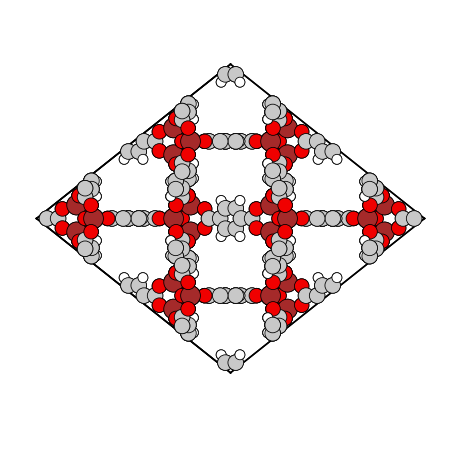

In [16]:
vis = Visualize(path_cif, make_supercell=True, show_cell=True, view_init=(0, -54), show_axis=False)
vis._ax.set_xlim3d((-11.497, 11.497))
vis._ax.set_ylim3d((20.730, 69.510))
vis._ax.set_zlim3d((-9.957, 9.957))
atoms = vis.view()
# vis.fig.savefig("figure/attention_visualize/0_irmof-1_supercell.jpg", dpi=300)

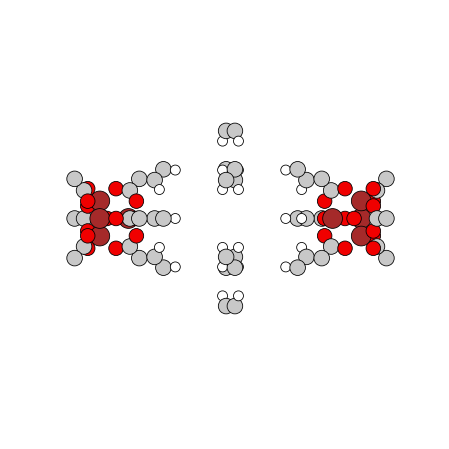

In [17]:
vis = Visualize(path_cif, make_supercell=False, show_cell=False, view_init=(0, 0))
vis.view()

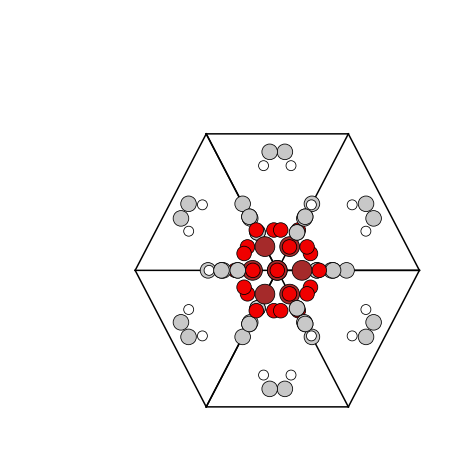

In [18]:
vis = Visualize(path_cif, make_supercell=False, show_cell=True, view_init=(0, 90), show_axis=False)
vis._ax.set_xlim3d((-3, 10))
vis._ax.set_zlim3d((-3, 10))
vis.view()
# vis.fig.savefig("figure/attention_visualize/0_irmof-1_cluster_90.jpg", dpi=300)

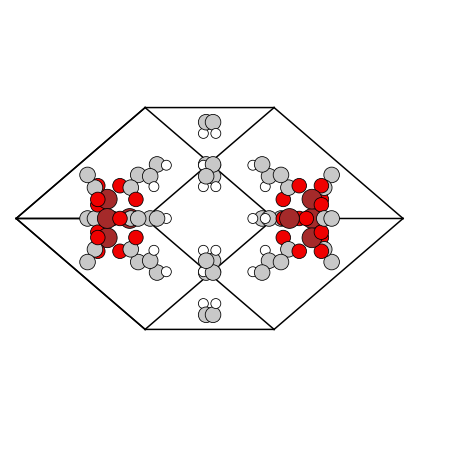

In [19]:
vis = Visualize(path_cif, make_supercell=False, show_cell=True, view_init=(0, 0), show_axis=False)
vis._ax.set_ylim3d((5, 45))
vis._ax.set_zlim3d((-8, 8))
vis.view()
# vis.fig.savefig("figure/attention_visualize/0_irmof-1_cluster_90.jpg", dpi=300)

In [182]:
# uni index
uni_idx = batch["uni_idx"][batch_idx]
vis = Visualize(path_cif, make_supercell=False, show_cell=True, show_uni_idx=True, view_init=(0, 90))
#vis._ax.set_xlim3d((-3, 10))
#vis._ax.set_zlim3d((-3, 10))
vis.view(uni_idx=uni_idx)

# get heatmap with attention rollout

In [109]:
out = model.infer(batch)
heatmap_graph, heatmap_grid = get_heatmap(out, batch_idx)
heatmap_graph[:30] *200/3

array([0.28120952, 0.43675545, 0.1440698 , 0.36582164, 0.22144298,
       0.28152699, 0.29200459, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

# Analysis attention

In [179]:
uni_idx = batch['uni_idx'][batch_idx]
atoms = read(path_cif)
for idx in uni_idx:
    print (atoms[idx])

Atoms(symbols='O24', pbc=True, cell=[[18.1188, 0.0, 0.0], [8.674400817206678, 16.00029157929455, 0.0], [8.656718375408119, 5.139018684498868, 15.201296546322718]], spacegroup_kinds=...)
Atoms(symbols='H12', pbc=True, cell=[[18.1188, 0.0, 0.0], [8.674400817206678, 16.00029157929455, 0.0], [8.656718375408119, 5.139018684498868, 15.201296546322718]], spacegroup_kinds=...)
Atoms(symbols='C12', pbc=True, cell=[[18.1188, 0.0, 0.0], [8.674400817206678, 16.00029157929455, 0.0], [8.656718375408119, 5.139018684498868, 15.201296546322718]], spacegroup_kinds=...)
Atoms(symbols='C12', pbc=True, cell=[[18.1188, 0.0, 0.0], [8.674400817206678, 16.00029157929455, 0.0], [8.656718375408119, 5.139018684498868, 15.201296546322718]], spacegroup_kinds=...)
Atoms(symbols='C12', pbc=True, cell=[[18.1188, 0.0, 0.0], [8.674400817206678, 16.00029157929455, 0.0], [8.656718375408119, 5.139018684498868, 15.201296546322718]], spacegroup_kinds=...)
Atoms(symbols='C12', pbc=True, cell=[[18.1188, 0.0, 0.0], [8.674400817

In [23]:
np.max(heatmap_graph[heatmap_graph!=0]), np.min(heatmap_graph[heatmap_graph!=0]), np.mean(heatmap_graph[heatmap_graph!=0])

(0.006175191540268326, 0.0013574959117968772, 0.0027957890491807852)

In [24]:
np.max(heatmap_grid), np.min(heatmap_grid), np.mean(heatmap_grid), np.sum(heatmap_grid)

(0.009999662711410503,
 0.002177462236610961,
 0.004488528539888669,
 0.9695221646159524)

In [25]:
max_gr = np.max(heatmap_graph[heatmap_graph!=0])/(np.max(heatmap_graph[heatmap_graph!=0])+np.max(heatmap_grid))
mean_gr = np.mean(heatmap_graph[heatmap_graph!=0])/(np.mean(heatmap_graph[heatmap_graph!=0])+np.mean(heatmap_grid))
#mean_gr = np.mean(heatmap_graph)/(np.mean(heatmap_graph)+np.mean(heatmap_grid))

print (f'MAX : {max_gr:.2f}:{1-max_gr:.2f}')
print (f'MEAN : {mean_gr:.2f}:{1-mean_gr:.2f}')

MAX : 0.38:0.62
MEAN : 0.38:0.62


# Test weight

In [81]:
total_vector = np.concatenate([heatmap_graph, heatmap_grid.flatten()])
total_vector = total_vector[total_vector!=0]

In [82]:
cal_vec = np.square(total_vector)/np.linalg.norm(np.square(total_vector))
cal_graph = cal_vec[:-216]
cal_grid = cal_vec[-216:]

In [85]:
(cal_grid * np.log(216)).max()

0.85277164

In [84]:
cal_graph * np.log(7)

array([0.08927695, 0.21535552, 0.02343286, 0.15108387, 0.05536089,
       0.08947864, 0.09626286], dtype=float32)

In [91]:
np.mean(heatmap_graph[heatmap_graph!=0]), np.mean(heatmap_grid)

(0.5526915, 0.5633725)

In [24]:
np.log(216), np.log(7)

(5.375278407684165, 1.9459101490553132)

# visulize graph + heatmap

In [26]:
# %matplotlib widget
%matplotlib inline

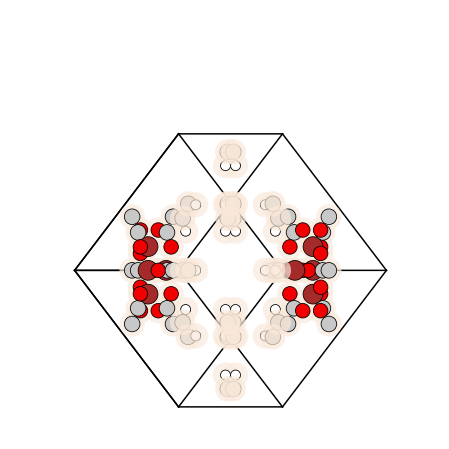

In [27]:
# uni index0
#%matplotlib
uni_idx = batch["uni_idx"][batch_idx]
vis = Visualize(path_cif, make_supercell=False, show_cell=True, show_colorbar=False, view_init=(0, 0))
vis._ax.set_xlim3d((-3, 10))
vis._ax.set_zlim3d((-3, 10))
vis.view(heatmap_graph=heatmap_graph, uni_idx=uni_idx)
# vis.fig.savefig("figure/attention_visualize/1_irmof-1_100_scaled_0.jpg", dpi=300) # for figure -> figsize=(20, 20)

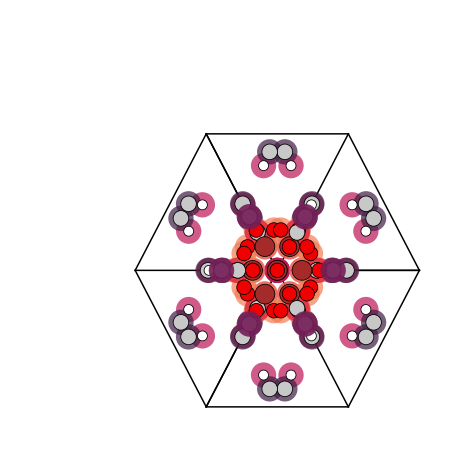

In [62]:
# uni index
uni_idx = batch["uni_idx"][batch_idx]
vis = Visualize(path_cif, make_supercell=False, show_cell=True, show_colorbar=False, view_init=(0, 90))
vis._ax.set_xlim3d((-3, 10))
vis._ax.set_zlim3d((-3, 10))
vis.view(heatmap_graph=heatmap_graph, uni_idx=uni_idx)
# vis.fig.savefig("figure/attention_visualize/1_irmof-1_100_scaled_90.jpg", dpi=300)

# visualize atoms (grid) + heatmap

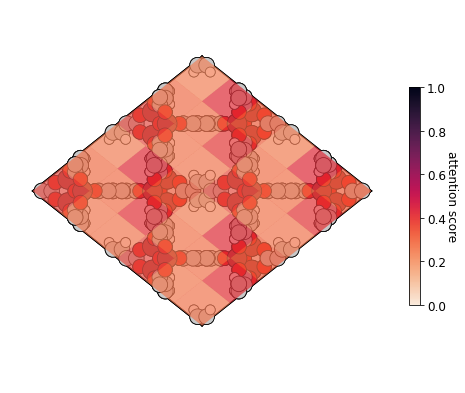

In [281]:
%matplotlib inline
vis = Visualize(path_cif, make_supercell=True, show_cell=True, view_init=(0, -54), show_axis=False,  show_colorbar=True)
vis._ax.set_xlim3d((-11.497, 11.497))
vis._ax.set_ylim3d((20.730, 69.510))
vis._ax.set_zlim3d((-9.957, 9.957))
vis.view(heatmap_grid=heatmap_grid*(1/0.013))
# vis.fig.savefig("figure/attention_visualize/1_irmof-1_100_scaled_grid.jpg", dpi=300)

# GET PATCH

In [93]:
class PatchVisualize(object):
    def __init__(self, path_cif,
                 make_supercell=False,
                figsize=(8,8),
                view_init=(0,0),
                show_axis=False,
                num_patch = (6,6,6)):

        self.path_cif = path_cif
        self.make_supercell = make_supercell
        self.figsize = figsize
        self.view_init = view_init
        self.show_axis = show_axis
        self.num_patch = num_patch

        self.fig = plt.figure(figsize=figsize)
        self._ax = self.fig.add_subplot(projection='3d')
        self.default_setting()
        
        self.atomic_scale = figsize[0] * figsize[1] * 5
        
        # get structure from cif
        st = self.get_primitive_structure(self.path_cif)
        atoms = AseAtomsAdaptor().get_atoms(st)

        # interpolate
        if self.make_supercell:
            atoms = self.get_supercell(st)
            
        self.atoms = atoms
        self.lattice = atoms.cell.array

        

    def default_setting(self):
        self._ax.view_init(*self.view_init)
        self._ax.set_proj_type("ortho")
        self._ax.grid(visible=False)

        if not self.show_axis:
            self._ax.set_axis_off()

        #self.color_palatte = sns.color_palette("rocket_r", as_cmap=True)
        self.color_palatte = sns.color_palette("light:midnightblue", as_cmap=True)

    @property
    def ax(self):
        return self._ax

    @ax.setter
    def ax(self, d):
        self._ax.update(d)

    def draw_atoms(self, atoms, factor=1):
        # draw atoms
        coords = atoms.get_positions()
        atomic_numbers = atoms.get_atomic_numbers()
        atomic_sizes = np.array([covalent_radii[i] for i in atomic_numbers])
        atomic_colors = np.array([cpk_colors[i] for i in atomic_numbers])
        self._ax.scatter(
            xs=coords[:, 0],
            ys=coords[:, 1],
            zs=coords[:, 2],
            c=atomic_colors,
            s=atomic_sizes * self.atomic_scale * factor,
            marker="o",
            edgecolor="black",
            linewidths=0.8,
            alpha=1.0,
        )
        
    
    def draw_line(self, pos1, pos2, **kwargs):
        self.ax.plot3D(*zip(pos1, pos2), **kwargs)

    def draw_cell(self, lattice, center=None, **kwargs):
        """
        draw cell using matplotlib
        :param cell:  lattice vectors (3 X 3 matrix)
        """
        # draw cell
        vec1, vec2, vec3 = lattice
        if center is None:
            center = np.zeros(3)

        opp_vec = vec1 + vec2 + vec3 + center

        for vec1, vec2 in combinations([vec1, vec2, vec3], 2):
            self.draw_line(center, center+vec1, **kwargs)
            self.draw_line(center, center+vec2, **kwargs)
            self.draw_line(center + vec1, center + vec1 + vec2, **kwargs)
            self.draw_line(center + vec2, center + vec1 + vec2, **kwargs)
            self.draw_line(center + vec1 + vec2, opp_vec, **kwargs)
            
    @staticmethod
    def get_primitive_structure(path_cif):
        st = CifParser(path_cif, occupancy_tolerance=2.0).get_structures(primitive=True)[0]
        return st

    @staticmethod
    def get_supercell(st, max_length=60, min_length=30):
        # make super-cell
        scale_abc = []
        for l in st.lattice.abc:
            if l > max_length:
                print(f"primitive cell is larger than max_length {max_length}")
                break
            elif l < min_length:
                scale_abc.append(math.ceil(min_length / l))
            else:
                scale_abc.append(1)

        st.make_supercell(scale_abc)
        atoms = AseAtomsAdaptor().get_atoms(st)

        # interpolate min_length and orthogonal
        # atoms.set_cell(np.identity(3) * min_length, scale_atoms=True)

        return atoms

    def draw_heatmap_grid(self, heatmap_grid, cell, positions=None, sizes=None):
        if positions is None:
            positions = [(1 * i, 1 * j, 1 * k) for i in range(6) for j in range(6) for k in range(6)]
        if sizes is None:
            sizes = [[1, 1, 1]] * 6 * 6 * 6
        
        cm_heatmap = self.color_palatte(heatmap_grid.flatten())

        pc = plot_cube_at3(positions, cell, sizes, colors=cm_heatmap, edgecolor=None, alpha=0.5)
        self._ax.add_collection3d(pc)

    
    def get_indice_inside_patch(self, patch_position, ep=0):
        def is_inside_patch(r_pos, pos_patch, num_patch):
            lower_bound = ((pos_patch-ep))/num_patch < r_pos
            upper_bound = r_pos < ((pos_patch+1+ep))/num_patch
            return np.logical_and(lower_bound, upper_bound)

        relative_position = self.atoms.get_scaled_positions()
        num_patch = self.num_patch
        position_bools = [is_inside_patch(r_pos, pos_patch, num_patch) 
                          for r_pos, pos_patch, num_patch in zip(relative_position.T, patch_position, self.num_patch)] # x, y, z

        position_bool =  np.logical_and.reduce(position_bools) # total
        indice, = np.where(position_bool)
        return indice
        
    def view(self, heatmap_grid, minatt=0.005, maxatt=0.015, num_patches=(6,6,6)):
        def scaler(value, minatt=minatt, maxatt=maxatt):
            return (value - minatt)/(maxatt - minatt)
            
        lattice = self.lattice
        
        positions = []
        sc_heatmap_grid = []
        sizes = []
        for i, j, k in product(*[range(n) for n in num_patches]):
            att = heatmap_grid[i,j,k]
            if att > maxatt:
                att = maxatt
            if att > minatt:
                positions.append((i, j, k))
                sizes.append([1, 1, 1])
                sc_heatmap_grid.append(scaler(att))
        sc_heatmap_grid = np.array(sc_heatmap_grid)
        #print (sc_heatmap_grid)
        
        self.draw_heatmap_grid(sc_heatmap_grid, lattice, positions, sizes)
        self.draw_cell(lattice, color='black')
        self.draw_atoms(self.atoms)
        
    def view_patch(self, patch_position, heatmap_grid, ep=0,  minatt=0, maxatt=1, color=True):
        def scaler(value, minatt=minatt, maxatt=maxatt):
            if value > maxatt:
                return 1.0
            elif value < minatt:
                return 0
            else:
                return (value - minatt)/(maxatt - minatt)
        
        # draw lattice
        indice = self.get_indice_inside_patch(patch_position, ep=ep)
        lattice = self.lattice
        #self.draw_cell(lattice, color="grey")
        
        self.draw_cell(lattice/6, center=np.sum(lattice.T/6 * patch_position, axis=1), color="black")
        
        self.draw_atoms(self.atoms[indice], factor=1)
        
        if color:
            heatmap_grid = np.array([scaler(heatmap_grid[tuple(patch_position)])])
            positions = [patch_position]
            sizes = [[1,1,1]]
            
            self.draw_heatmap_grid(heatmap_grid, lattice, positions, sizes)
        
        
    def view_patch_list(self, patch_list, heatmap_grid, minatt=0, maxatt=1):
        def scaler(values, minatt=minatt, maxatt=maxatt):
            sc_value = []
            for value in values:
                if value > maxatt:
                    value = maxatt
                sc_value.append((value - minatt)/(maxatt - minatt))
            return sc_value
        
        lattice = self.lattice
        self.draw_cell(lattice, color='black')
        self.draw_atoms(self.atoms)
        
        positions = patch_list
        sizes = [[1, 1, 1]] * len(positions)
        sc_heatmap_grid = scaler([heatmap_grid[tuple(p)] for p in patch_list])
        sc_heatmap_grid = np.array(sc_heatmap_grid)
        
        self.draw_heatmap_grid(sc_heatmap_grid, lattice, positions, sizes)
        

# 기능
view(heatmap_grid, minatt, maxatt) : minatt과 maxatt사이를 plot (maxatt보다 높으면 maxatt로 취급)

view_patch_list(patch_list, heatmap_grid) : patch_list에 있는 position들만 plot (밑에 예시 있음)

view_patch(patch_position, heatmap_grid, ep) : 한 patch를 visuallize (ep는 주변 patch의 개수이다. 0이면 그 패치만, 1이면 바로옆패치까지. 소수점 가능)

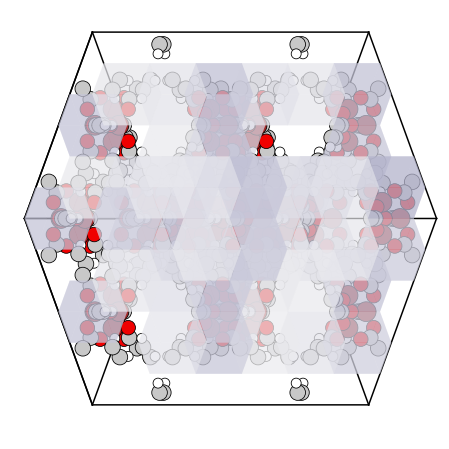

In [42]:
%matplotlib inline

# Draw patch list

p_vis = PatchVisualize(path_cif, make_supercell=True, view_init=(0, 34),figsize=(8,8))
p_vis._ax.set_xlim3d((-11.497, 11.497))
p_vis._ax.set_ylim3d((20.730, 69.510))
p_vis._ax.set_zlim3d((-9.957, 9.957))
p_vis.view(heatmap_grid, 0.005, 0.01)

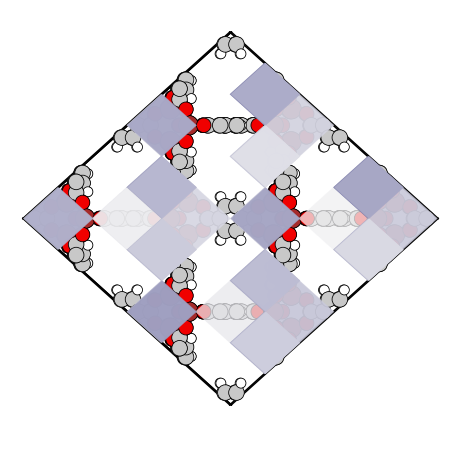

In [114]:
%matplotlib inline

# Draw patch list

p_vis = PatchVisualize(path_cif, make_supercell=True, view_init=(0, -34),figsize=(8,8))
p_vis._ax.set_xlim3d((-11.497, 11.497))
p_vis._ax.set_ylim3d((20.730, 69.510))
p_vis._ax.set_zlim3d((-9.957, 9.957))
p_vis.view(heatmap_grid, 0.005, 0.01)

# Top N patches

In [112]:
min_idx = np.array(np.unravel_index(np.argsort(heatmap_grid, axis=None,), heatmap_grid.shape))[:,-30:].T   # MAX IDX
#min_idx = np.array(np.unravel_index(np.argsort(heatmap_grid, axis=None,), heatmap_grid.shape))[:,:30].T   # MIN IDX

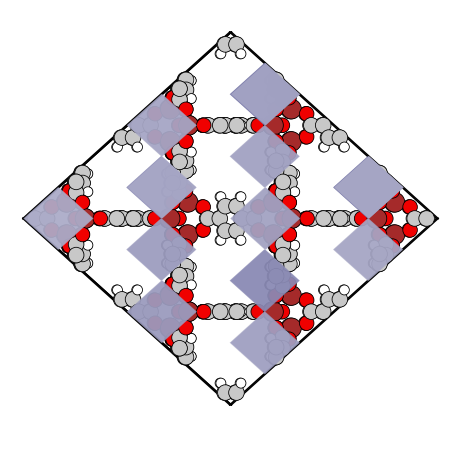

In [113]:
%matplotlib inline

# Draw patch list

p_vis = PatchVisualize(path_cif, make_supercell=True, view_init=(0, -34),figsize=(8,8))
p_vis._ax.set_xlim3d((-11.497, 11.497))
p_vis._ax.set_ylim3d((20.730, 69.510))
p_vis._ax.set_zlim3d((-9.957, 9.957))
p_vis.view_patch_list(min_idx, heatmap_grid, minatt=0.005, maxatt=0.01)

# Draw one patch

In [116]:
%matplotlib

rank = 0
patch_position = np.array(np.unravel_index(np.argsort(heatmap_grid, axis=None,), heatmap_grid.shape))[:,rank]
print ('value', heatmap_grid[tuple(patch_position)])
#print (heatmap_grid[patch_position])
p_vis = PatchVisualize(path_cif, make_supercell=True, view_init=(0, -34),figsize=(8,8))
p_vis._ax.set_xlim3d((-11.497, 11.497))
p_vis._ax.set_ylim3d((20.730, 69.510))
p_vis._ax.set_zlim3d((-9.957, 9.957))
p_vis.view_patch(patch_position, heatmap_grid, ep=0.5, maxatt=0.01, minatt=0.005)

Using matplotlib backend: TkAgg
value 0.002174780833327718


# Draw position patchn

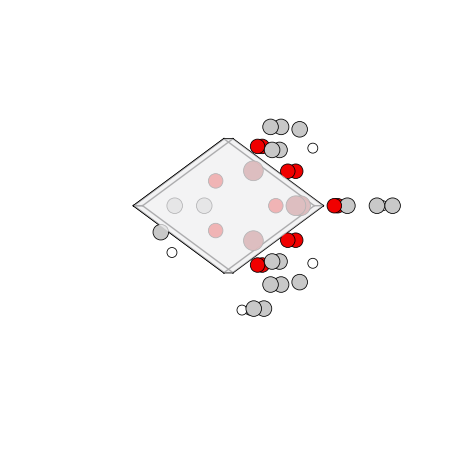

In [415]:
%matplotlib inline
patch_position = np.array([3, 0, 0])
p_vis = PatchVisualize(path_cif, make_supercell=True, view_init=(0, -34),figsize=(8,8))
# p_vis._ax.set_xlim3d((-11.497, 11.497))
# p_vis._ax.set_ylim3d((20.730, 69.510))
# p_vis._ax.set_zlim3d((-9.957, 9.957))
p_vis.view_patch(patch_position, heatmap_grid, ep=0.5)

# Histogram

Text(0, 0.5, 'Number of Patches')

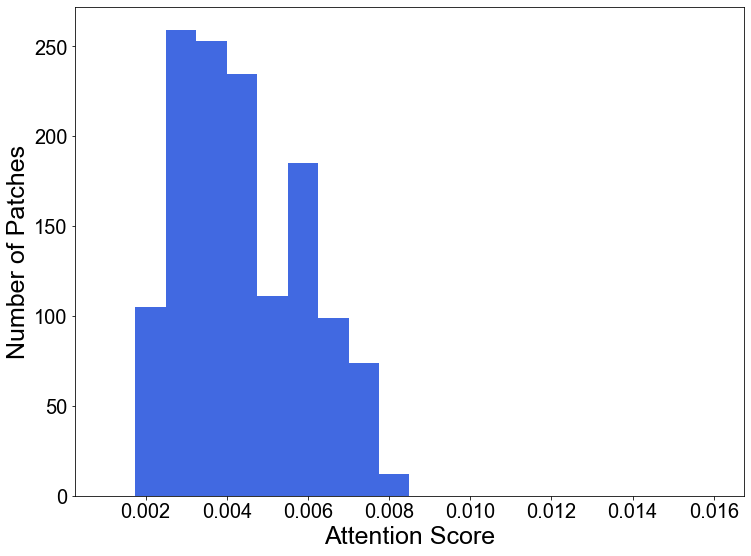

In [184]:
%matplotlib inline
plt.rcParams['font.size']=20
plt.rcParams['font.family']='arial'
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
plt.hist(heatmap_grid.flatten(), bins=20, range=(0.001, 0.016), color='royalblue', density=True, alpha=1)
plt.xlabel('Attention Score', fontsize=25)
plt.ylabel('Number of Patches', fontsize=25)
#plt.xlim(0.15, 1)

Text(0, 0.5, 'Density of Atoms')

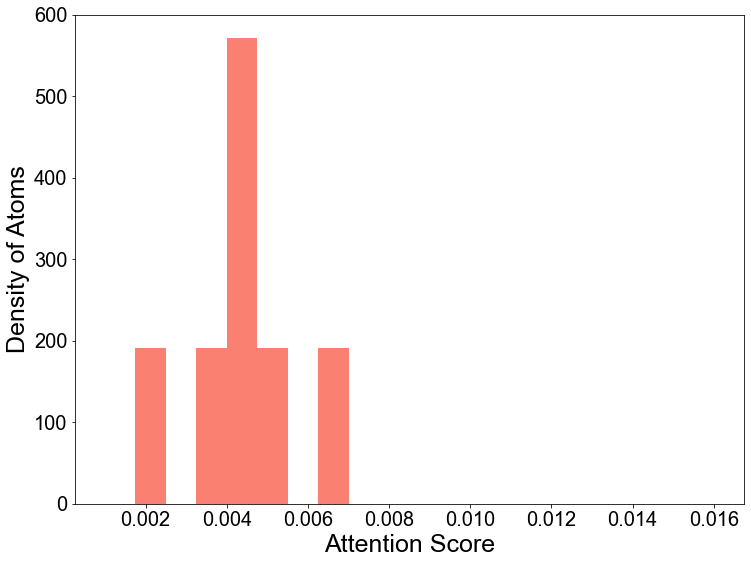

In [417]:
%matplotlib inline
plt.rcParams['font.size']=20
plt.rcParams['font.family']='arial'
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

plt.hist(heatmap_graph.flatten(), bins=20, range=(0.001, 0.016), color='salmon', density=True, alpha=1)
plt.xlabel('Attention Score', fontsize=25)
plt.ylabel('Density of Atoms', fontsize=25)
#plt.xlim(0.15, 1)

# EG analysis

In [78]:
def get_grid_patch(batch_idx, idx):
    griddata = batch['grid'][batch_idx].numpy().squeeze()
    size = 5
    i, j, k = idx
    return griddata[i*size:(i+1)*size, j*size:(j+1)*size, k*size:(k+1)*size]

get_grid_patch(batch_idx, max_idx)

array([[[102.      , 102.      , 101.18906 ,  48.881077,  40.665874],
        [102.      , 102.      ,  90.24137 ,  43.592144,  39.051132],
        [102.      , 102.      , 102.      ,  92.844246,  58.485233],
        [102.      , 102.      , 102.      , 102.      , 102.      ],
        [102.      , 102.      , 102.      , 102.      , 102.      ]],

       [[102.      , 102.      , 101.30632 ,  49.42395 ,  38.980976],
        [102.      , 102.      ,  76.56695 ,  40.123867,  39.4664  ],
        [100.34382 ,  60.599304,  54.254063,  43.75217 ,  39.856827],
        [ 69.88596 ,  89.053375, 100.015015,  85.745804,  91.649124],
        [102.      , 102.      , 102.      , 102.      , 102.      ]],

       [[102.      , 102.      , 101.99008 ,  58.763786,  74.082436],
        [102.      , 102.      , 101.42708 ,  77.68892 ,  37.357864],
        [100.33911 , 100.218735,  99.963554,  72.790054,  49.694542],
        [ 51.41879 ,  98.07881 , 101.858215,  70.81722 ,  95.45838 ],
        [ 68.040

# Absorption analysis

In [41]:
import re
from collections import Counter
from itertools import chain, product

In [37]:
movie_dir = Path(f'/home/dudgns1675/data/gcmc/IRMOF_movie/{prop}/')
movie = next(movie_dir.glob(f'Movie_{cif_id}*.pdb'))

In [38]:
def get_position(movie):
    with open(movie) as f:
        data = f.read()
    state = re.split('MODEL\s+[0-9]+\n', data)
    atom_ls = []
    for s in state:
        #print ('1', s.strip()[1:])
        atoms = s.strip().split("\n")[1:-1]
        atoms = [line.split()[4:7] for line in atoms]
        if atoms:
            atoms = np.array(atoms, dtype=float)
            atom_ls.append(atoms)
    return atom_ls

In [58]:
def get_patch(movie, num_patch=(6,6,6)):
    positions = get_position(movie)
    cell = read(path_cif).cell.array
    vec = re.search(r"(?<=_)(\d\.\d\.\d)(?=_)", str(movie)).group().split('.')
    
    #print (cell, vec)
    
    data_ls = []
    for position in positions:
        data = np.matmul(position, np.linalg.inv(cell * np.array(vec, dtype='int')))
        assert data.max() <= 1
        assert data.min() >= 0, data.min()
    
        data =  data * np.array(num_patch)
        data =  data.astype('int')
        data = [tuple(p) for p in tuple(data)]
        data_ls.append(data)
        
    return list(chain.from_iterable(data_ls))
    
hd_patch = get_patch(movie)

In [43]:
hd_counter = Counter(hd_patch)

In [44]:
data = []
for i, j, k in product(range(6), range(6), range(6)):
    att = heatmap_grid[(i,j,k)]
    num_h = hd_counter.get((i,j,k), 0)
    data.append((att, num_h))

In [45]:
x, y = zip(*data)

43.64453125


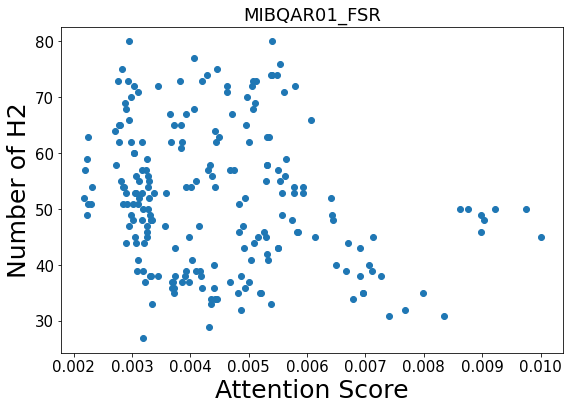

In [46]:
plt.rcParams['figure.figsize']=(9,6)
plt.rcParams['font.size']=15
plt.scatter(x, y)
plt.ylabel('Number of H2', fontsize=25)
plt.xlabel('Attention Score', fontsize=25)
plt.title(cif_id)
print (len(hd_patch)/256)

# High Patch Relationship

In [33]:
print(batch["cif_id"])
batch_idx = 0
cif_id = batch["cif_id"][batch_idx]
path_cif = f"/home/data/pretrained_mof/ver4/example/test/{cif_id}.cif"

['MIBQAR01_FSR', 'MOF-5_cooh_2_573_2', 'MOF-5_cooh_2_42_1', 'core_NEXVET_freeONLY', 'DOTSOV01_FSR', 'gmof_Uio66Zr-BDC_A_No1']


In [32]:
uptake_data = {'MIBQAR01_FSR' : 588.269, 'gmof_Uio66Zr-BDC_A_No1':457.758, 'DOTSOV01_FSR':537.59, 'MOF-5_cooh_2_42_1':572.46, 'MOF-5_cooh_2_573_2':500.126, 'core_NEXVET_freeONLY':580.7287437776}

In [79]:
data = []
for batch_idx in range(6):
    #batch_idx = 0
    cif_id = batch["cif_id"][batch_idx]
    path_cif = f"/home/data/pretrained_mof/ver4/example/test/{cif_id}.cif"
    
    movie_dir = Path(f'/home/dudgns1675/data/gcmc/IRMOF_movie/{prop}/')
    movie = next(movie_dir.glob(f'Movie_{cif_id}*.pdb'))
    
    hd_patch = get_patch(movie)
    hd_counter = Counter(hd_patch)
    
    out = model.infer(batch)
    heatmap_graph, heatmap_grid = get_heatmap(out, batch_idx)
    max_idx = np.array(np.unravel_index(np.argsort(heatmap_grid, axis=None,), heatmap_grid.shape))[:,-1]
    
    eg = get_grid_patch(batch_idx, max_idx)
    
    #data.append((hd_counter[tuple(max_idx)], uptake_data[cif_id]))
    data.append((np.mean(eg), uptake_data[cif_id]))
    

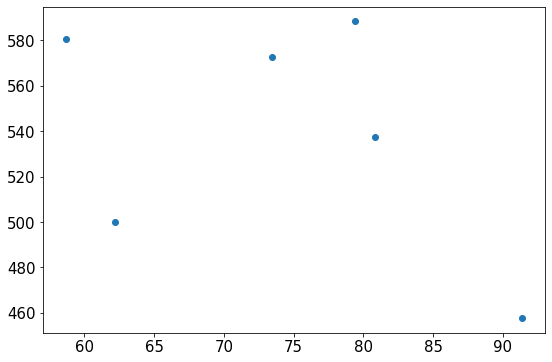

In [80]:
plt.scatter(*zip(*data))

In [81]:
batch['cif_id']

['MIBQAR01_FSR',
 'MOF-5_cooh_2_573_2',
 'MOF-5_cooh_2_42_1',
 'core_NEXVET_freeONLY',
 'DOTSOV01_FSR',
 'gmof_Uio66Zr-BDC_A_No1']

# save figure

In [27]:
%matplotlib inline
downstreams = ["100_scaled", "5_scaled", "bandgap"]
losses = ["mtp_moc", "mtp_moc_vfp"]
for loss in losses:
    
    # pretraining
    print(f"best_ckpt/best_{loss}.ckpt")
    _config["load_path"] = f"best_ckpt/best_{loss}.ckpt"

    # set model
    pl.seed_everything(_config["seed"])
    model = Module(_config)
    model.setup("test")
    model.eval()
    device = "cpu"
    model.to(device)
    
    #  get heatmap
    out = model.infer(batch)
    heatmap_graph, heatmap_grid = get_heatmap(out, batch_idx, skip_cls=True)

    # 1. (0, 0)
    uni_idx = batch["uni_idx"][batch_idx]
    vis = Visualize(path_cif, interpolate=False, show_cell=True, show_colorbar=False, view_init=(0, 0))
    xlim_ = vis._ax.set_xlim3d(orig_xlim)
    ylim_ = vis._ax.set_ylim3d(orig_ylim)
    zlim_ = vis._ax.set_zlim3d(orig_zlim)
    vis.view(heatmap_graph=heatmap_graph, uni_idx=uni_idx)
    vis.fig.savefig(f"figure/attention_visualize/{loss}_irmof-1_0.jpg", dpi=300)
      
    
    # 2. (0, 90)
    uni_idx = batch["uni_idx"][batch_idx]
    vis = Visualize(path_cif, interpolate=False, show_cell=True, show_colorbar=False, view_init=(0, 90))
    xlim_ = vis._ax.set_xlim3d(orig_xlim)
    ylim_ = vis._ax.set_ylim3d(orig_ylim)
    zlim_ = vis._ax.set_zlim3d(orig_zlim)
    vis.view(heatmap_graph=heatmap_graph, uni_idx=uni_idx)
    vis.fig.savefig(f"figure/attention_visualize/{loss}_irmof-1_90.jpg", dpi=300)

    # 2. grid
    vis = Visualize(path_cif, interpolate=True, show_cell=True, show_colorbar=True)
    vis.view(heatmap_grid=heatmap_grid)
    vis.fig.savefig(f"figure/attention_visualize/{loss}_irmof-1_grid.jpg", dpi=300)
    
    plt.cla()
    
    # downstream
    for ds in downstreams:
        print(f"best_ckpt/{ds}_{loss}.ckpt")
        _config["load_path"] = f"best_ckpt/{ds}_{loss}.ckpt"
        # set model
        pl.seed_everything(_config["seed"])
        model = Module(_config)
        model.setup("test")
        model.eval()
        device = "cpu"
        model.to(device)
        
        #  get heatmap
        out = model.infer(batch)
        heatmap_graph, heatmap_grid = get_heatmap(out, batch_idx, skip_cls=True)
        
        # 1. (0, 0)
        uni_idx = batch["uni_idx"][batch_idx]
        vis = Visualize(path_cif, interpolate=False, show_cell=True, show_colorbar=False, view_init=(0, 0))
        xlim_ = vis._ax.set_xlim3d(orig_xlim)
        ylim_ = vis._ax.set_ylim3d(orig_ylim)
        zlim_ = vis._ax.set_zlim3d(orig_zlim)
        vis.view(heatmap_graph=heatmap_graph, uni_idx=uni_idx)
        vis.fig.savefig(f"figure/attention_visualize/{loss}_irmof-1_{ds}_0.jpg", dpi=300)
        
        # 2. (0, 90)
        uni_idx = batch["uni_idx"][batch_idx]
        vis = Visualize(path_cif, interpolate=False, show_cell=True, show_colorbar=False, view_init=(0, 90))
        xlim_ = vis._ax.set_xlim3d(orig_xlim)
        ylim_ = vis._ax.set_ylim3d(orig_ylim)
        zlim_ = vis._ax.set_zlim3d(orig_zlim)
        vis.view(heatmap_graph=heatmap_graph, uni_idx=uni_idx)
        vis.fig.savefig(f"figure/attention_visualize/{loss}_irmof-1_{ds}_90.jpg", dpi=300)
    
        # 2. grid
        vis = Visualize(path_cif, interpolate=True, show_cell=True, show_colorbar=True)
        vis.view(heatmap_grid=heatmap_grid)
        vis.fig.savefig(f"figure/attention_visualize/{loss}_irmof-1_{ds}_grid.jpg", dpi=300)
        
        plt.cla()

Global seed set to 0


best_ckpt/best_mtp_moc.ckpt
load model : best_ckpt/best_mtp_moc.ckpt


TypeError: __init__() got an unexpected keyword argument 'interpolate'

In [28]:
heatmap_grid.shape

(6, 6, 6)